## Import Relevant Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

## Import .csv file and convert into DataFrame

In [323]:
data = pd.read_csv("C:/Users/mdara/Jupyter/Untitled Folder/Stout Projects/Case Study 1/loans_full_schema.csv")
loan_data = data.copy()


(10000, 55)

## Feature Engineering and Deletion of Features

In [126]:
#Condense annual income and joint annual income into Total annual income
loan_data['annual_income_joint'] = loan_data['annual_income_joint'].replace(np.nan, 0)
loan_data['total_income'] = loan_data.loc[:,'annual_income_joint']+loan_data.loc[:,'annual_income']

#Condense debt_to_income and debt_to_income_joint into total_debt_to_income
loan_data['debt_to_income_joint'] = loan_data['debt_to_income_joint'].replace(np.nan, 0)
loan_data['total_debt_to_income'] = loan_data.loc[:,'debt_to_income_joint']+loan_data.loc[:,'debt_to_income']

#Replace missing values in 'months_since_last_delinq' to 0 (assuming NaN means no deliquency)
loan_data['months_since_last_delinq'] = loan_data['months_since_last_delinq'].replace(np.nan, 0)

#Replace missing values in 'months_since_90d_late' to 0 (assuming NaN means no 90d late)
loan_data['months_since_90d_late'] = loan_data['months_since_90d_late'].replace(np.nan, 0)

#Replace missing values in 'months_since_last_credit_inquiry' to 0 (assuming NaN means no credit enquiry)
loan_data['months_since_last_credit_inquiry'] = loan_data['months_since_last_credit_inquiry'].replace(np.nan, 0)

#Replace missing values in 'debi_to_income' by the median of the feature
loan_data['debt_to_income'] = loan_data['debt_to_income'].replace(np.nan, loan_data['debt_to_income'].dropna().median())

#Replace missing values in 'total_debt_to_income' by the median of the feature
loan_data = loan_data.replace(np.nan,loan_data['total_debt_to_income'].median())

#Drop annual_income and annual_income_joint
loan_data = loan_data.drop(['annual_income', 'annual_income_joint'], axis=1)

#Drop debt_to_income and debt_to_income_joint
loan_data = loan_data.drop(['debt_to_income','debt_to_income_joint'], axis=1)

#Drop verification_income_joint as it is same as verificaition_income
loan_data = loan_data.drop(['verification_income_joint'], axis=1)


## Check Correlation between interest rates and features

In [128]:
corr = loan_data.corr()
print(corr['interest_rate'].sort_values(ascending = False))

interest_rate                       1.000000
paid_interest                       0.514508
term                                0.358664
total_debt_to_income                0.148045
inquiries_last_12m                  0.131193
accounts_opened_24m                 0.120657
earliest_credit_line                0.103635
installment                         0.098811
delinq_2y                           0.090456
months_since_90d_late               0.086418
num_cc_carrying_balance             0.081741
months_since_last_delinq            0.069373
balance                             0.067570
paid_total                          0.065339
loan_amount                         0.064527
num_accounts_120d_past_due          0.050373
public_record_bankrupt              0.047477
current_installment_accounts        0.047131
num_historical_failed_to_pay        0.037563
total_credit_utilized               0.031527
num_collections_last_12m            0.029901
num_active_debit_accounts           0.026800
paid_late_

## Create new feature list based on correlation

In [143]:
loan_data_corr = loan_data[['interest_rate','paid_interest','term','total_debt_to_income',
                      'inquiries_last_12m','accounts_opened_24m',
                      'earliest_credit_line','total_debit_limit',
                      'num_mort_accounts','total_credit_limit',
                      'account_never_delinq_percent']].copy()

#Create list of all feature names
cat_att = list(['homeownership','verified_income','loan_purpose',
              'application_type','grade','sub_grade',
              'loan_status'])
num_att = list(loan_data_corr.columns)

#First, combine specific columns to form the new dataframe loan
loan = pd.concat([loan_data_corr, loan_data.loc[:,cat_att]], axis=1)

#Then, create dummies for all categorical features
cat_dummies = pd.DataFrame(pd.get_dummies(loan.loc[:,cat_att])) 

#Lastly, replace categorical features with dummy categorical features
loan = loan.drop(cat_att, axis = 1)
loan = pd.concat([loan, cat_dummies], axis=1)

## Split dataset into training and testing dataset

In [149]:
train, test = train_test_split(loan, random_state=42, test_size=0.3)

#Split train and test set into X(features) and Y(target)
trainY = train['interest_rate'].copy()
trainX = train.drop(['interest_rate'], axis=1)

testY = test['interest_rate'].copy()
testX = test.drop(['interest_rate'], axis = 1)

#Maintain list of all column names for convenience
cat_att_tr = list(trainX.select_dtypes(['object']).columns)
num_att_tr = list(trainX.select_dtypes(['number']).columns)

cat_att_ts = list(testX.select_dtypes(['object']).columns)
num_att_ts = list(testX.select_dtypes(['number']).columns)

## Scale the numerical Data 

In [197]:
#Create Standard Scaler object
stdsc = StandardScaler()

#Scale the training and testing numerical data
trainX.loc[:,num_att_tr] = stdsc.fit_transform(trainX.loc[:,num_att_tr])
testX.loc[:,num_att_ts] = stdsc.transform(testX.loc[:,num_att_ts])


##  Model 1 - RandomForestRegressor

In [201]:
#RandomForestRegressor
rf = RandomForestRegressor(max_features= 8, n_estimators= 30).fit(trainX, trainY)
train_predictions = rf.predict(trainX)
rf_rmse = np.sqrt(mean_squared_error(trainY, train_predictions))

#Using the testing data
final_predictions = rf.predict(testX)

final_mse = mean_squared_error(testY, final_predictions)
final_rmse = np.sqrt(final_mse)

print(rf_rmse, final_rmse)

# The RandomForestRegressor model does much better on the training 
# set compared to the testing set because it is overfitting the
# training set.

0.1882880994690728 4.888477688499647


## Model 2 - Prediction using XGBoost

In [232]:
xgb_model = XGBRegressor()
xgb_model.fit(trainX, trainY)

predictions = xgb_model.predict(trainX)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, trainY)))

final_pred = xgb_model.predict(testX)
print(mean_absolute_error(final_pred, testY))

#XGBoost also does much better on the training set than the 
#testing set, overfitting seems to be the same reason. Upon
#tuning the hyperparameters I wasn't able to improve the performance.
#The model performs best with default parameters. 
#Given more time, a deep dive into this issue and reducing overfitting
#will improve its performance


Mean Absolute Error : 0.01212196648461476
2.4793826629193627


## Visualizations

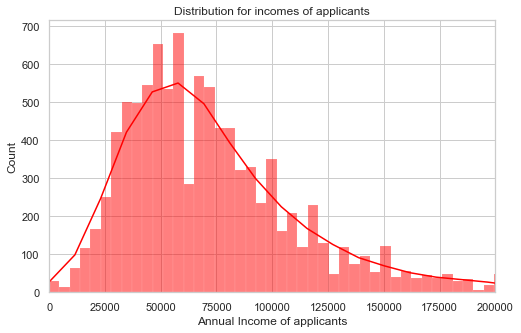

In [265]:
fig1, ax1 = plt.subplots(figsize = (8,5))
sns.set_theme(style="whitegrid")
ax1 = sns.histplot(data.annual_income, 
                   kde=True,color='Red').set(title = 'Distribution for incomes of applicants')
plt.xlim(0, 200000)
plt.xlabel('Annual Income of applicants')
plt.show()

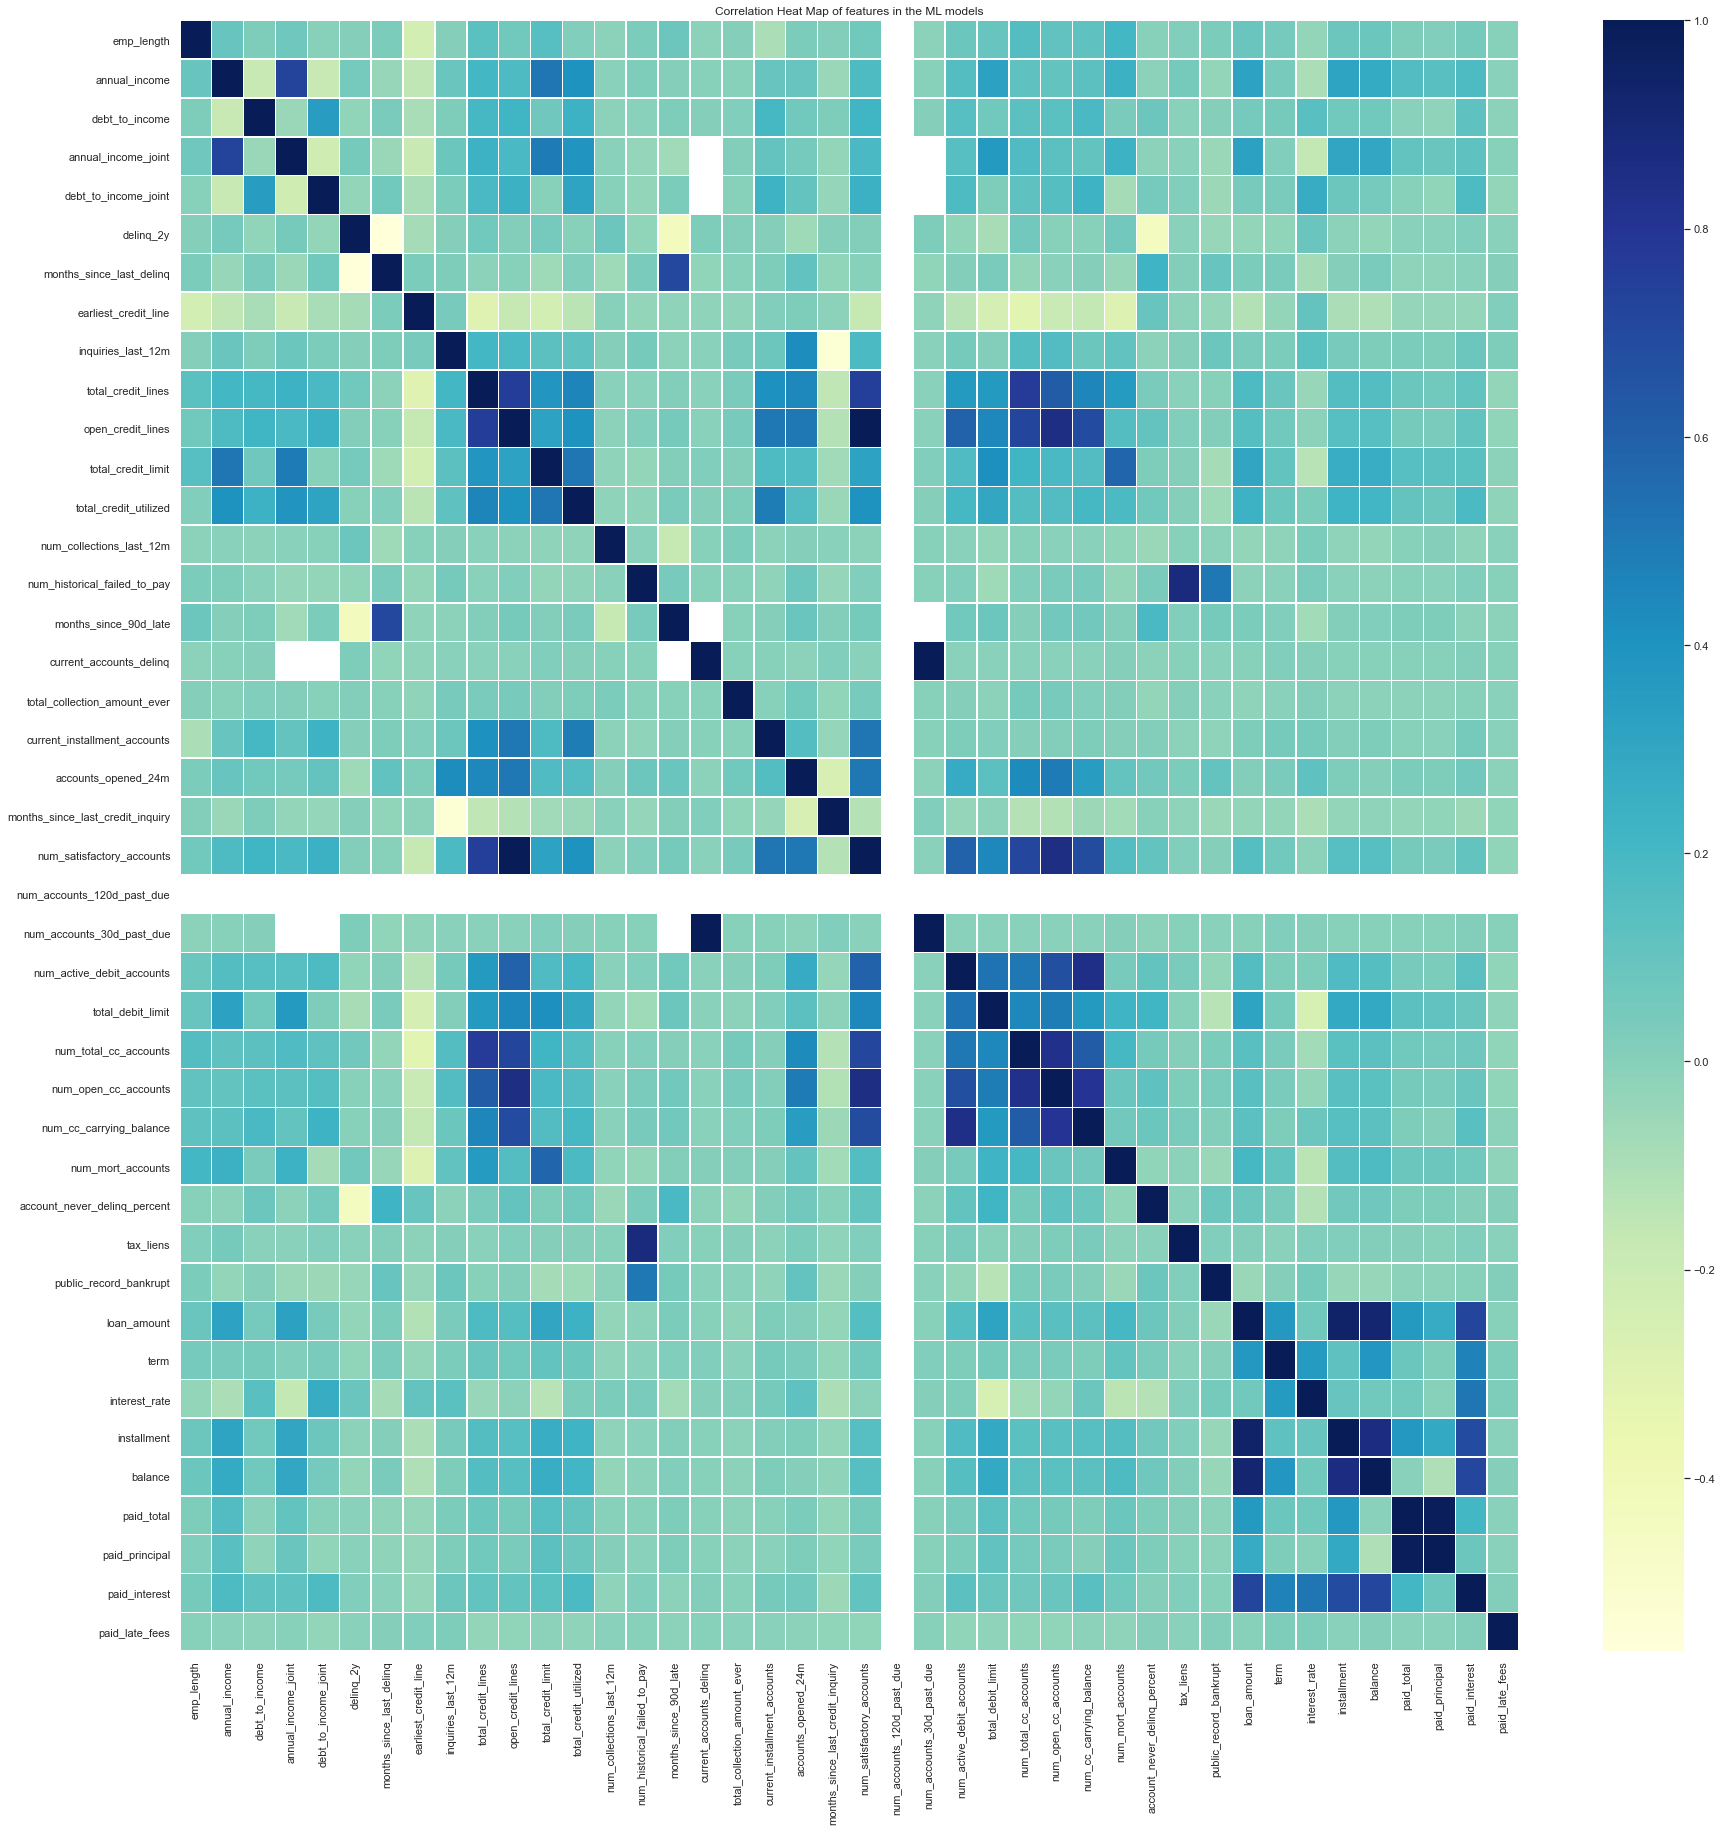

In [285]:
corr_matrix = data.corr()

fig1, ax1 = plt.subplots(figsize = (30,30))

ax1 = sns.heatmap(corr_matrix,linewidths=.5, cmap="YlGnBu")
plt.title("Correlation Heat Map of features in the ML models")
plt.show()

The heatmap above show the correlation between features,
dark hues suggest strong positive correlation, light hues suggest strong negative correlation.
For ex - A higher loan amount correlates to a higher monthly 
installment

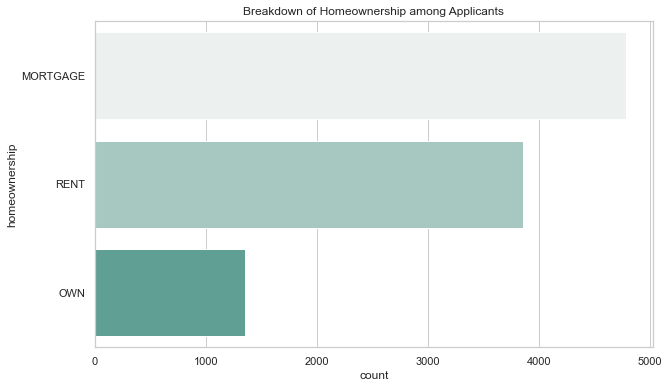

In [307]:
fig2, ax2 = plt.subplots(figsize = (10,6))
sns.countplot(y = 'homeownership', data = data, palette = 'light:#5A9')
plt.title('Breakdown of Homeownership among Applicants')
plt.show()

There is a sizeable population of applicants that are living on rent,showing a strong desire to purchase houses as an investment.

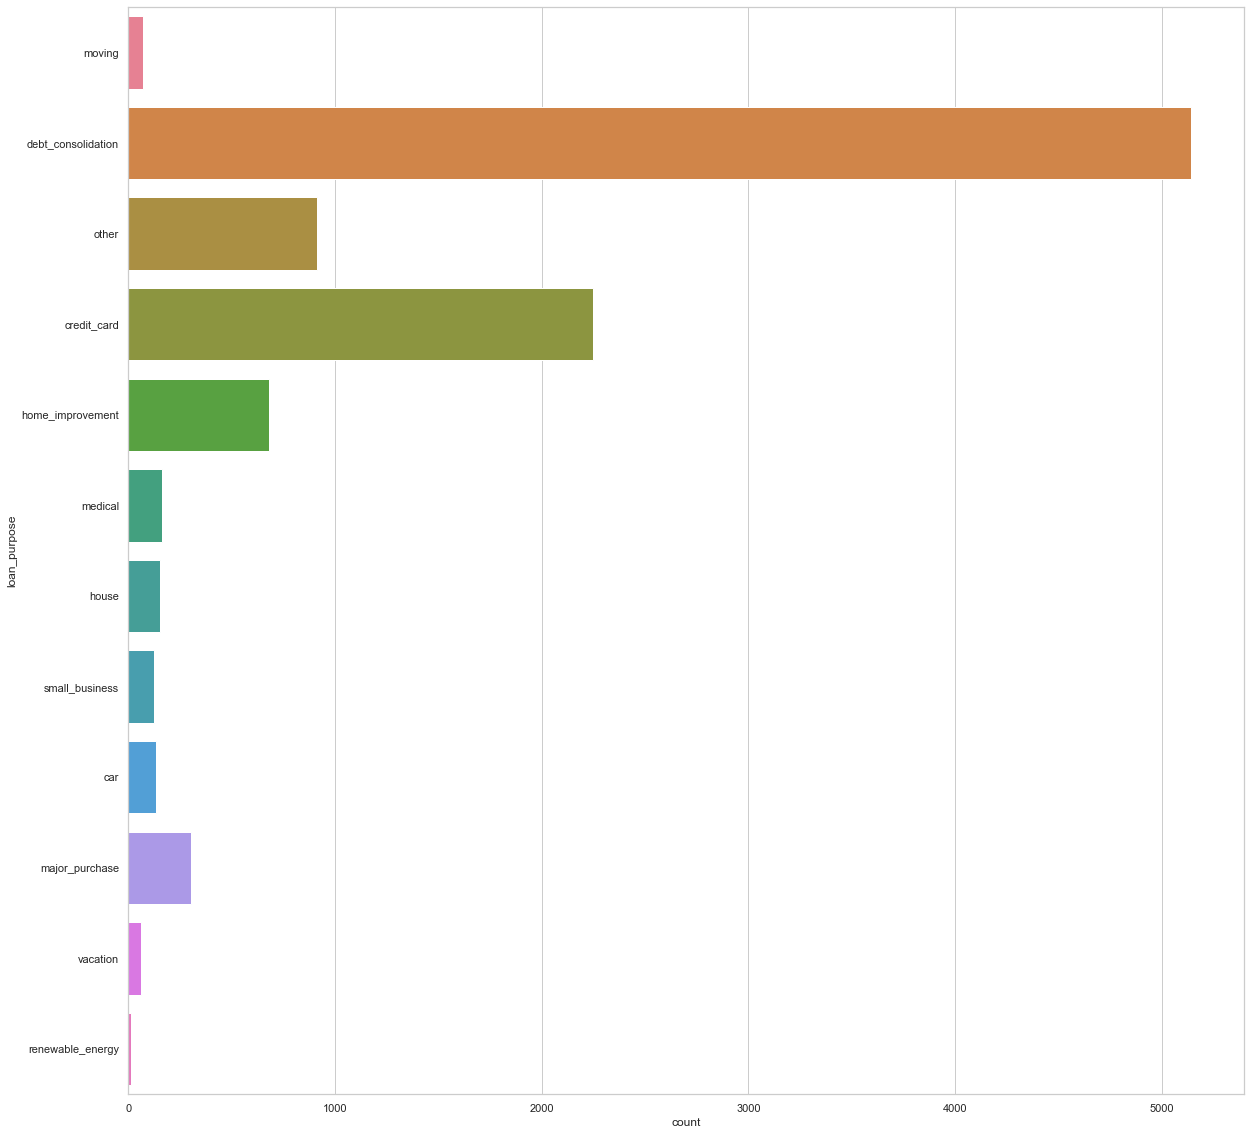

In [316]:
fig3, ax3 = plt.subplots(figsize = (20,20))
ax3 = sns.countplot(y=data.loan_purpose,palette = 'husl')
plt.show()

Loans are overwhelming given out to customers for consolidation of their other debts i.e Credit card debt, student loan debt etc.

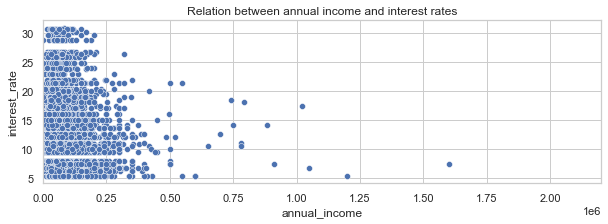

In [322]:
fig4, ax4 = plt.subplots(figsize = (10,3))
ax4 = sns.scatterplot(y=data.interest_rate,x=data.annual_income,
                      palette = 'light:#5A9').set_title(
    'Relation between annual income and interest rates')
plt.xlim(0,2.2e6)
plt.show()

People with higher annual income prove to be safer borrowers,
hence receiving a low rate of interest.q